# Прототип модели предсказывающей коэффициент восстановления золота из золотосодержащей руды

[Загрузка и подготовка данных](#Загрузка-и-подготовка-данных)

[Анализ данных](#Анализ-данных)

[Прототип модели](#Прототип-модели)

# Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import plotly.express as px
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
full = pd.read_csv('/datasets/gold_recovery_full.csv')

def info(df): #Функция пробегает по признакам датафрейма и если тип у признака object, то смотрит уникальные значения, в противном случае оценивается распределение
    for column in df.columns:
        
        print(df[column].describe())
        print()
    
        if df[column].dtype == 'object':
            
            print(column)
            print(df[column].unique())
                    
        else:
            
            print(column)
            fig = px.histogram(df, x = column, marginal = 'box', title = 'Распределение '+ column)
            fig.show()
            
#info(train)
#print('+++++++++++++++++++++++++++++')
#info(test)
#print('+++++++++++++++++++++++++++++')
#info(full)

In [2]:
result = [b for b in train.columns if
          all(a not in b for a in test.columns)]
print(len(result))
list(result)

34


['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

In [3]:
def check_nulls(data):
    print(data.isnull().sum())
    
check_nulls(train['rougher.output.concentrate_au'])
check_nulls(train['rougher.input.feed_au'])
check_nulls(train['rougher.output.tail_au'])

train = train.replace(0, float('Nan')).dropna()

check_nulls(train)
print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
check_nulls(test)
print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
check_nulls (full)
train = train.ffill(axis = 1) 
check_nulls(train)

test = test.replace(0, float('Nan')).dropna()
test = test.ffill(axis = 1) 

82
83
2249
date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.

In [4]:
def check_duplicates (data):
    print(data.duplicated().sum())
    
check_duplicates (train)
check_duplicates (test)
check_duplicates (full)

0
0
0


In [5]:
# Проверьте, что эффективность обогащения рассчитана правильно. 
# Вычислите её на обучающей выборке для признака rougher.output.recovery.
# Найдите MAE между вашими расчётами и значением признака.

def recovery (C, F, T):
    result = ((C*(F-T))/(F*(C-T)))*100
    return result 

In [6]:
def calc_recovery (row):
    row['rougher.output.recovery_check'] = recovery(row['rougher.output.concentrate_au'], row['rougher.input.feed_au'], row['rougher.output.tail_au'])
    return row

train = train.apply(calc_recovery, axis=1)

mae = mean_absolute_error(train['rougher.output.recovery'], train['rougher.output.recovery_check'])
print('MAE=', mae)

MAE= 9.74932337097378e-15


## Вывод 

* Таблицы открыты и изучены. Таблица train имеет 16860 строк и 87 столбцов. Таблица test имеет 5856 строк и 53 столбца. Таблица full имеет 22716 строк и 87 столбцов. Имеется обширное множество пропущенных значений. Дубликатов не обнаружено. Оценили распределение некоторых признаков.
* Оценка МАЕ минимальна, она близка к нулю. Это значит, что эффективность обогащения рассчитана верно и данную функцию расчета по формуле можно применять для дальнейшей работы.
* Признаки, имеющиеся в трейне и недоступные в тестовой выборке относятся к типу "output — параметры продукта". То есть данные, которые характеризуют продукт после химических преобразований.
* Пропуски в данных заполнили методом ffill. Он позволяет заполнить пропущенное значение предыдущим имеющимся значением. Думаю, что этот метод заполнения нам подойдёт, так как есть информация, что соседние по времени параметры часто похожи.

# Анализ данных

## Исследование изменений концентраций металлов на различных этапах очистки

[Text(0, 0.5, 'concentration'),
 Text(0.5, 0, 'date'),
 Text(0.5, 1.0, 'Variation Pb concentration at different stages of cleaning')]

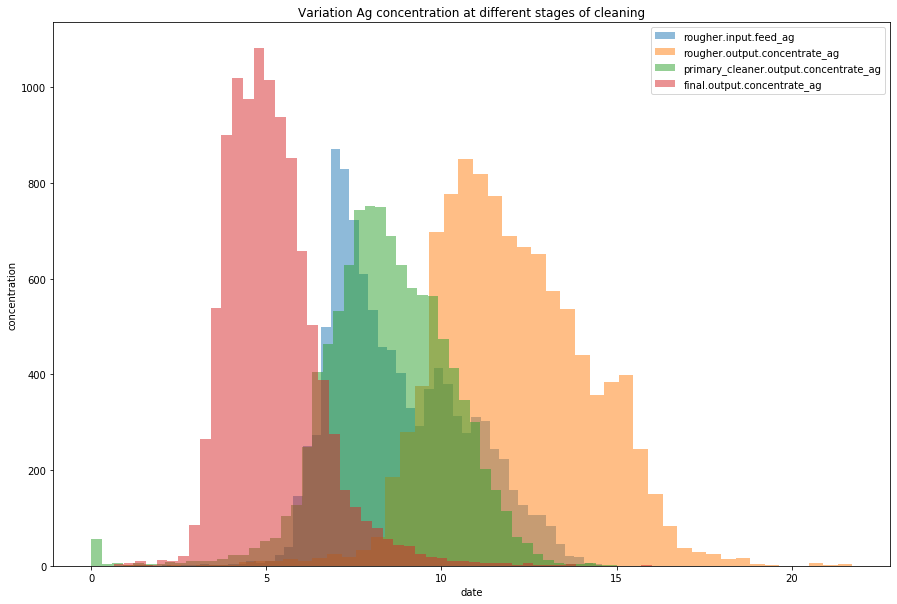

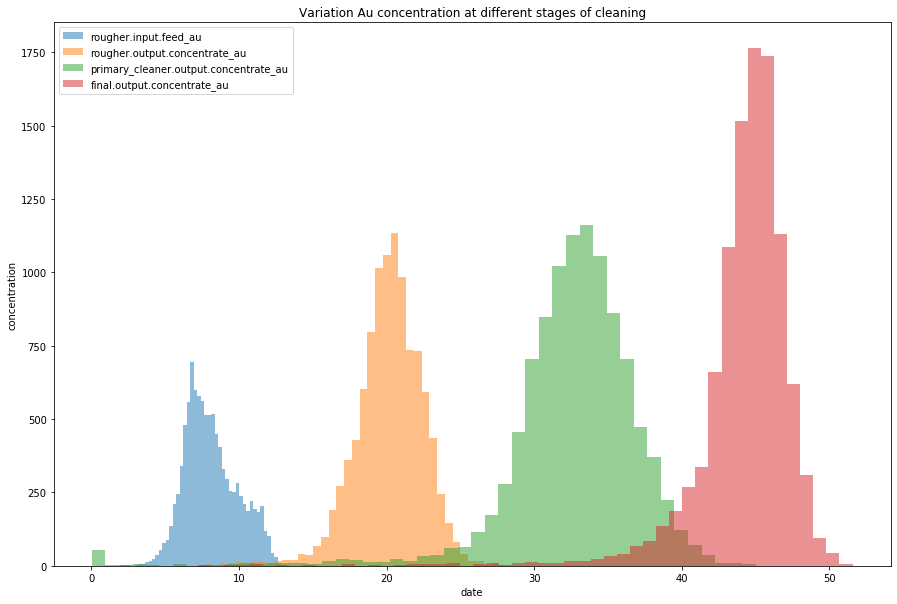

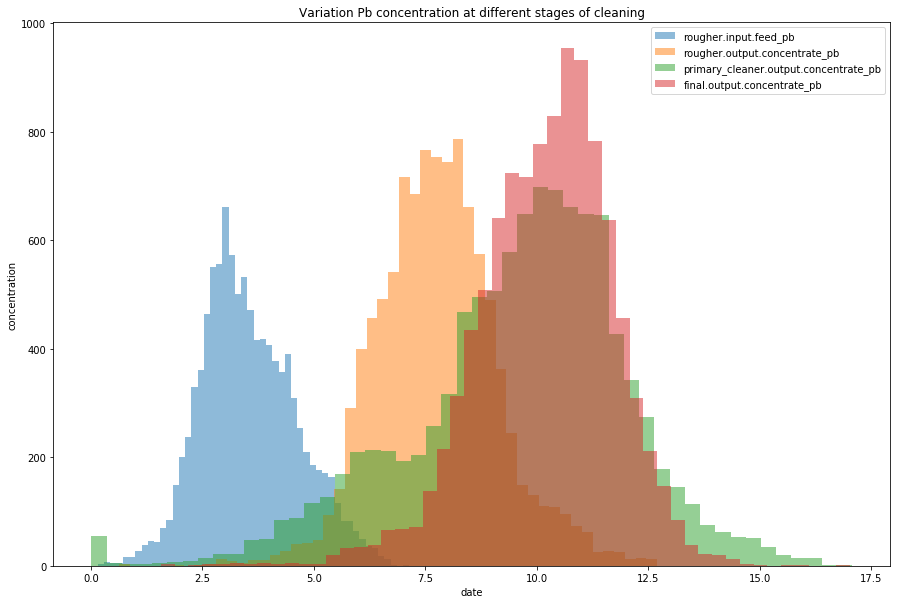

In [7]:
def make_me_plot (df, column1, column2, column3, column4): 
    rougher_input_plot = df.plot(kind='hist', x = 'date', y = column1, alpha=0.5, bins=50, label = column1)
    rougher_output_plot = df.plot(kind='hist',  x = 'date', y = column2, alpha=0.5, bins=50, label = column2, ax=rougher_input_plot)
    primary_cleaner_plot = df.plot(kind='hist', x = 'date', y = column3, alpha=0.5, bins=50, label = column3, ax=rougher_output_plot, grid = True, legend = True)
    final_output_plot = df.plot(figsize=(15,10), kind='hist', x = 'date', y = column4, alpha=0.5, bins=50, label = column4, ax=primary_cleaner_plot)
    return final_output_plot
    
Ag_plot = make_me_plot(train, 'rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag')
Ag_plot.set(xlabel='date', ylabel='concentration', title='Variation Ag concentration at different stages of cleaning')
Au_plot = make_me_plot(train, 'rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au')
Au_plot.set(xlabel='date', ylabel='concentration', title='Variation Au concentration at different stages of cleaning')
Pb_plot = make_me_plot(train, 'rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb')
Pb_plot.set(xlabel='date', ylabel='concentration', title='Variation Pb concentration at different stages of cleaning')

## Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

[Text(0, 0.5, 'Feed size'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Distribution of raw material granules before primary cleaning')]

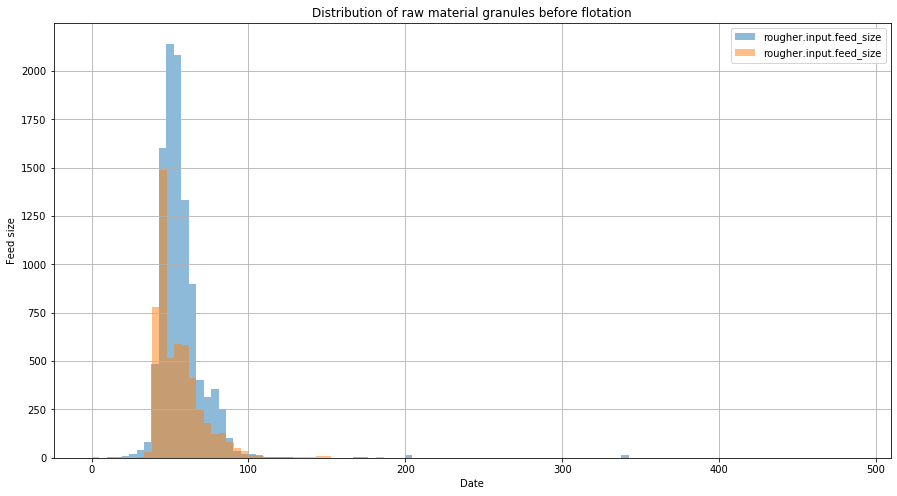

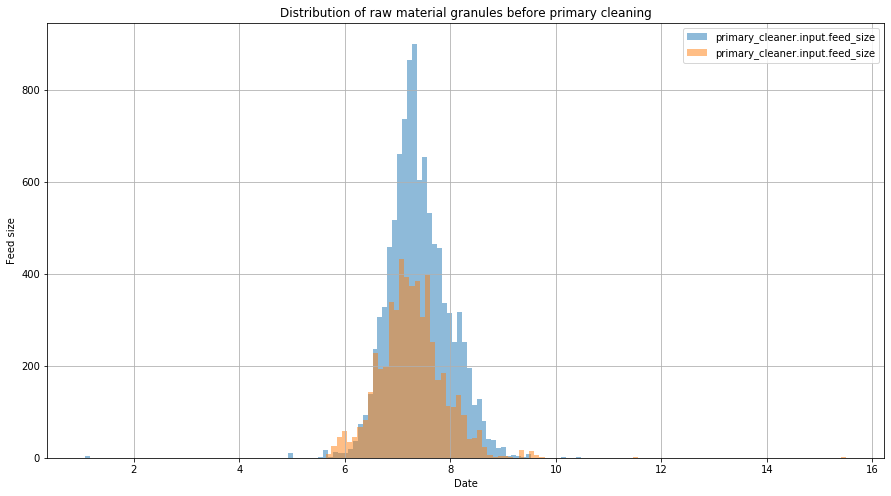

In [8]:
# rougher.input.feed_size 
rougher_input_feed_size = train.plot(kind='hist', x = 'date', y = 'rougher.input.feed_size', alpha=0.5, bins=100, label = 'rougher.input.feed_size')
rougher_input_feed_size_plot = test.plot(figsize=(15,8), kind='hist',  x = 'date', y = 'rougher.input.feed_size', alpha=0.5, bins=100, label = 'rougher.input.feed_size', ax=rougher_input_feed_size, grid = True, legend = True)

rougher_input_feed_size_plot.set(xlabel='Date', ylabel='Feed size', title='Distribution of raw material granules before flotation' )

# primary_cleaner.input.feed_size
primary_cleaner_input_feed_size = train.plot(kind='hist', x = 'date', y = 'primary_cleaner.input.feed_size', alpha=0.5, bins=100, label = 'primary_cleaner.input.feed_size')
primary_cleaner_input_feed_size_plot = test.plot(figsize=(15,8), kind='hist',  x = 'date', y = 'primary_cleaner.input.feed_size', alpha=0.5, bins=100, label = 'primary_cleaner.input.feed_size', ax=primary_cleaner_input_feed_size, grid = True, legend = True)

primary_cleaner_input_feed_size_plot.set(xlabel='Date', ylabel='Feed size', title='Distribution of raw material granules before primary cleaning')


## Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

[Text(0, 0.5, 'Substance concentration'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Total concentration of all substances at different stages')]

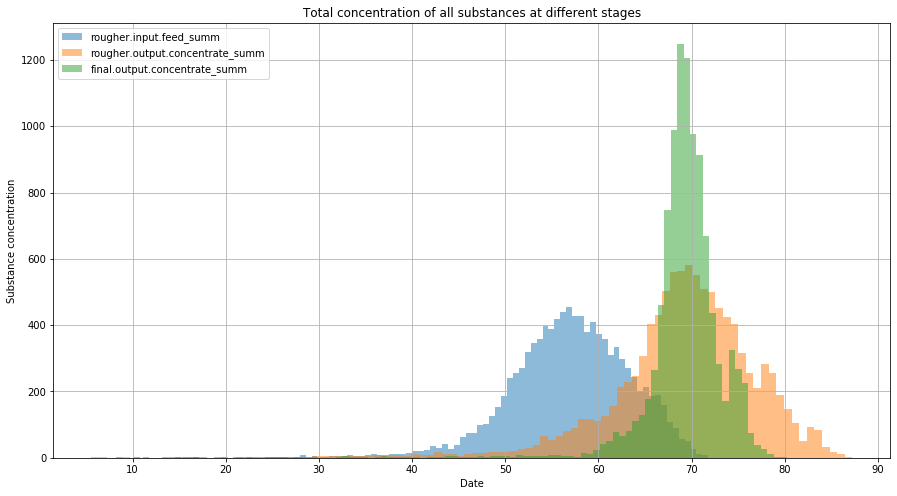

In [9]:
# rougher.input.feed_ag + rougher.input.feed_au + rougher.input.feed_pb + rougher.input.feed_sol

train['rougher.input.feed_summ'] = train['rougher.input.feed_ag'] + train['rougher.input.feed_pb'] + train['rougher.input.feed_au'] + train['rougher.input.feed_sol']
# display(train['rougher.input.summ'].head())
train['rougher.output.concentrate_summ'] = train['rougher.output.concentrate_ag'] + train['rougher.output.concentrate_pb'] + train['rougher.output.concentrate_au'] + train['rougher.output.concentrate_sol']
train['final.output.concentrate_summ'] = train['final.output.concentrate_ag'] + train['final.output.concentrate_pb'] + train['final.output.concentrate_au'] + train['final.output.concentrate_sol']

feed_summ_plot = train.plot(kind='hist', x = 'date', y = 'rougher.input.feed_summ', alpha=0.5, bins=100, label = 'rougher.input.feed_summ')
rougher_summ_plot = train.plot(kind='hist', x = 'date', y = 'rougher.output.concentrate_summ', alpha=0.5, bins=100, label = 'rougher.output.concentrate_summ', ax = feed_summ_plot)
final_summ_plot = train.plot(figsize=(15,8), kind='hist', x = 'date', y = 'final.output.concentrate_summ', alpha=0.5, bins=100, label = 'final.output.concentrate_summ', ax = rougher_summ_plot, grid = True, legend = True)

final_summ_plot.set(xlabel='Date', ylabel='Substance concentration', title='Total concentration of all substances at different stages')

## Вывод

2.1. На различных этапах очистки концентрация металлов меняется. Максимума концентрация достигает на финальном этапе очистки.

2.2. Распределение размеров гранул сырья на обучающей и тестовой выборках практически совпадает.

2.3. Суммарная концентрация всех веществ на финальной стадии значительно выше, чем в сырье и черновом концентрате.

# Прототип модели

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
import warnings
warnings.filterwarnings("ignore")

### Расчёт sMAPE

In [11]:
# Удаляем из train колонки, которых нет в test

test = test.merge(full[['rougher.output.recovery', 'final.output.recovery', 'date']], how='left', on='date')
# display(test['rougher.output.recovery'].head())

test = test.drop(['date'] , axis=1)
train = train[test.columns]

In [12]:
test.shape, train.shape

((5357, 54), (10285, 54))

In [13]:
from sklearn.metrics import make_scorer

def sMAPE(predictions, targ):
    y = np.absolute(targ - predictions)
    y_1 = np.absolute(targ)
    y_2 = np.absolute(predictions)

    return ((y / ((y_1 + y_2)/2)).sum() / len(targ)) * 100

def sMAPE_final(y, y_pred):
    predictions_list_rougher_output_recovery = np.array(list(zip(*y_pred))[0])
    predictions_list_final_output_recovery = np.array(list(zip(*y_pred))[1])

    sMAPE_1 = sMAPE(predictions_list_rougher_output_recovery, y['rougher.output.recovery'])
    sMAPE_2 = sMAPE(predictions_list_final_output_recovery, y['final.output.recovery'])

    final_sMAPE = 0.25 * sMAPE_1 + 0.75 * sMAPE_2

    return final_sMAPE

sMAPE_scorer = make_scorer(sMAPE_final, greater_is_better=False)

In [14]:
# Линейная регрессия
features_train = train.drop(['rougher.output.recovery', 'final.output.recovery'] , axis=1)
target_train = train[['rougher.output.recovery', 'final.output.recovery']]

model_regression = LinearRegression() # инициализируем модель 
model_regression.fit(features_train, target_train) # обучаем модель на тренировочной выборке
cross_val_scores = cross_val_score(model_regression, features_train, target_train, cv=5, scoring=sMAPE_scorer)

print("Средняя оценка LinearRegression = ", cross_val_scores.mean())
print(cross_val_scores)

Средняя оценка LinearRegression =  -8.328215531727555
[ -9.47789497  -7.33563786  -6.22260834  -7.98924475 -10.61569174]


In [15]:
# Дерево решений
model_tree = DecisionTreeRegressor(random_state=12345, max_depth=15)
model_tree.fit(features_train, target_train) # обучаем модель на тренировочной выборке
cross_val_scores = cross_val_score(model_tree, features_train, target_train, cv=5, scoring=sMAPE_scorer)

print("Средняя оценка DecisionTreeRegressor = ", cross_val_scores.mean())

Средняя оценка DecisionTreeRegressor =  -12.871792932757756


In [16]:
# Cлучайный лес

model_forest = RandomForestRegressor(random_state=12345, max_depth=5, n_estimators = 8, min_samples_leaf = 5) 
model_forest.fit(features_train, target_train) # обучаем модель на тренировочной выборке
cross_val_scores = cross_val_score(model_forest, features_train, target_train, cv=5, scoring=sMAPE_scorer)

print("Средняя оценка RandomForestRegressor = ", cross_val_scores.mean())

Средняя оценка RandomForestRegressor =  -8.591902749373663


In [17]:
# Линейная регрессия TEST
features_test = test.drop(['rougher.output.recovery', 'final.output.recovery'] , axis=1)
target_test = test[['rougher.output.recovery', 'final.output.recovery']]

predicted_valid = model_regression.predict(features_test)

print('final_sMAPE = ', sMAPE_final(test, predicted_valid))

final_sMAPE =  9.132761611746446


In [18]:
target_train_median = target_train[['rougher.output.recovery', 'final.output.recovery']].median()
# print(target_test_median)
train_len = len(target_train)
target_train_median_fake_predict = np.full((train_len, 2), [target_train_median['rougher.output.recovery'], target_train_median['final.output.recovery']])
# print(target_test_median_fake_predict)

print('median_sMAPE = ', sMAPE_final(train, target_train_median_fake_predict))

median_sMAPE =  8.430067250873986


## Вывод 

3.1. Написана функция для вычисления финального sMAPE.

3.2. Обучены различные модели ( LinearRegression, DecisionTreeRegressor, RandomForestRegressor ), выбраны модели - регрессоры, а не классифаеры, так как у нас не стоит задача классификации. Согласно кросс-валидации LinearRegression является самой близкой к нулю(смотрим по модулю), а значит она самая лучшая из рассмотренных. Лучшая модель проверена на тестовом наборе данных, и рассчитано sMAPE. Низкое значение sMAPE говорит нам об отличной пригодности выбранной модели. Значение sMAPE нашей лучшей модели и средняя рассчитанная по медианным значениям метрика sMAPE примерно равны.